***
# <span style='color:Blue'>Customer churn in a Telecom Industry</span>

#### <span style='color:Blue'>Import the required packages</span>

In [1]:
# Load required modules

import pandas as pd              # Perform operations on data frames
import numpy as np               # Perform numeric operations on data
import matplotlib.pyplot as plt  # For static visualizations
import seaborn as sns            # For advanced visualizations
import pickle
from IPython.display import HTML
import math
import scipy.stats as stats      # To perform statistical operations
from sklearn.model_selection import GridSearchCV  # To perform grid search for optimal parameters
from sklearn.model_selection import train_test_split

# Load diffrent classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# To support the backend renedering of figures
%matplotlib inline

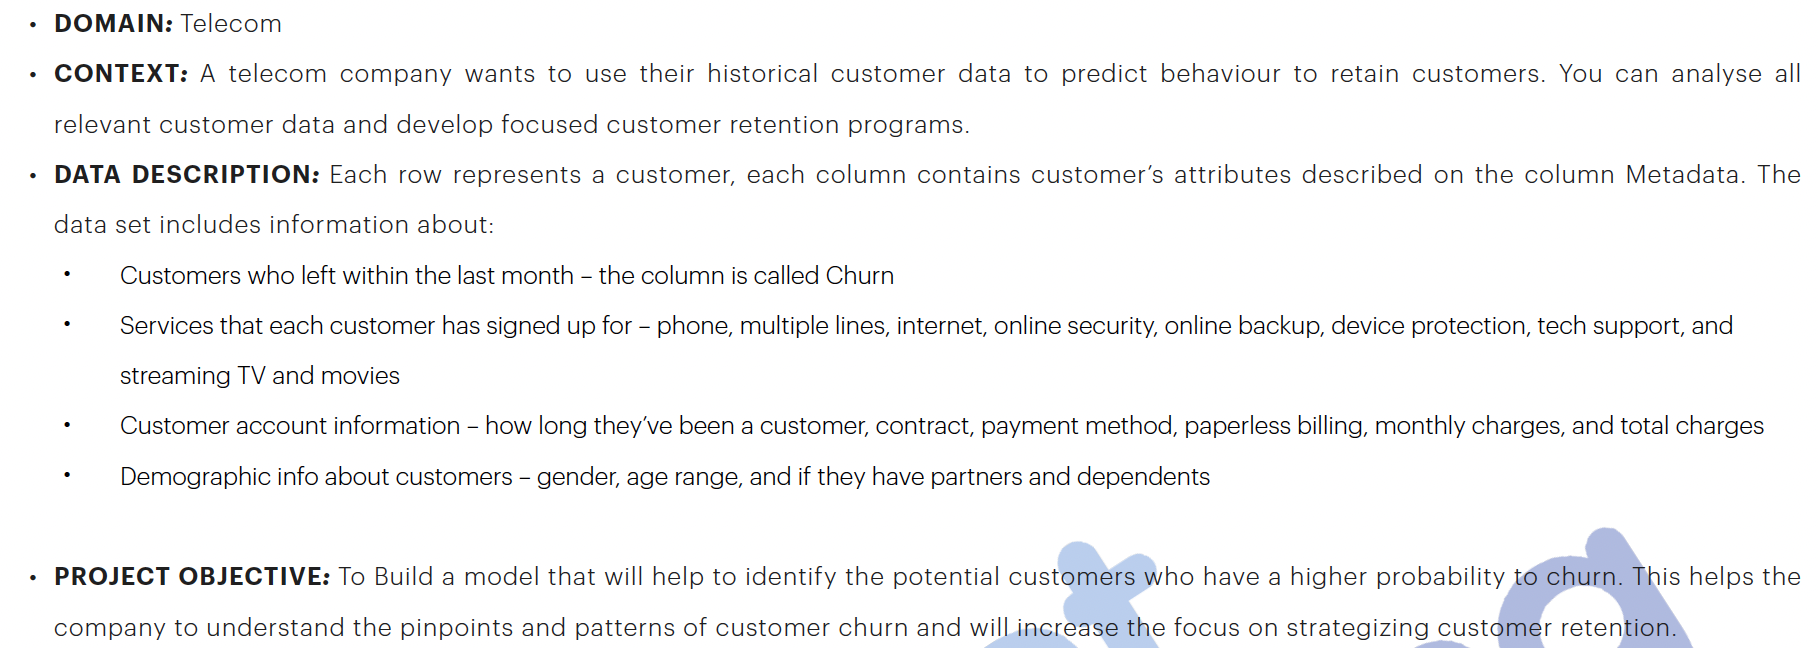

### Data Understanding & Exploration

In [2]:
telecomDf1 = pd.read_csv("TelcomCustomer-Churn_1.csv")

In [3]:
telecomDf1.shape

(7043, 10)

In [4]:
telecomDf2 = pd.read_csv("TelcomCustomer-Churn_2.csv")

In [5]:
telecomDf2.shape

(7043, 12)

#### Merge both the DataFrames on key ‘customerID’ to form a single DataFrame

In [6]:
telecomDf = pd.merge(telecomDf1, telecomDf2, on="customerID")

In [7]:
telecomDf.shape

(7043, 21)

#### Verify if all the columns are incorporated in the merged DataFrame

In [8]:
telecomDf1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity'],
      dtype='object')

In [9]:
telecomDf2.columns

Index(['customerID', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
set(telecomDf.columns) == set(list(telecomDf1.columns) + list(telecomDf2.columns))

True

**<span style="color:blue">Observations</span>**
- The above comparison of columns in merged dataframe and columns in individual dataframes returned `True`
- This verfies that all the columns are incorporated in the merged dataframe 

## Data Cleaning & Analysis

#### Impute missing/unexpected values in the DataFrame

In [11]:
telecomDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
# check if any customerID is duplicated
len(telecomDf['customerID']) == len(set(telecomDf['customerID']))

True

This confirms that no customerID is duplicated, else number of customerIDs would be less in the set of customerID than list of customerID

In [13]:
telecomDf.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**<span style="color:blue">Observations</span>**
- It can be seen that the `TotalCharges` column type should be `float` but it has been shown as of type `object`.
- There might be few character values inserted in the column. Let's try to find those values and treat them appropriately

In [14]:
strVals = [] # store character/string values
numVals = [] # store numeric values
for value in telecomDf['TotalCharges']:
    try:
        v = float(value)
        numVals.append(v)
    except:
        strVals.append(value)

In [15]:
pd.Series(strVals).value_counts()

     11
dtype: int64

**<span style="color:blue">Observations</span>**
- It can been seen that there are 11 observations with " " space character i.e. missing value for `TotalCharges`
- Let's impute them with `mean` of _TotalCharges_

In [16]:
fVals = []
for value in telecomDf['TotalCharges']:
    try:
        fVals.append(float(value))
    except:
        fVals.append(np.mean(numVals)) # numeric values, numVals, for TotalCharges were obtained in previous step

In [17]:
telecomDf['TotalCharges'] = fVals

In [18]:
telecomDf['TotalCharges'].dtype

dtype('float64')

**<span style="color:blue">Comment</span>**
- Missing values in `TotalCharges` column are successfully imputed with mean and converted to `float` type 

#### Make sure all the variables with continuous values are of ‘Float’ type

In [19]:
telecomDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**<span style="color:blue">Observations</span>**
- Now, it can be seen that the columns with continuous values i.e. `MonthlyCharges` and `TotalCharges` are of `float` type

#### Function that will accept a DataFrame as input and return pie-charts for all the appropriate categorical features

As customerID column is just an identifier for the observation i.e. customer, and does not serve as a feature, let's remove it from the dataframe for further operations

In [20]:
telecomDf.drop(columns=['customerID'], inplace=True)

Lets convert the columns with an 'object' datatype into categorical variables

In [21]:
for feature in telecomDf.columns: # Loop through all columns in the dataframe
    if telecomDf[feature].dtype == 'object': # Only apply for columns with categorical strings
        telecomDf[feature] = pd.Categorical(telecomDf[feature])# Replace strings with an integer

In [22]:
telecomDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   int64   
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [23]:
# Write a function to generate pie charts for all the categorical columns in the given dataframe

def generatePieCharts(dataframe):
    categoryCols = []
    for feature in dataframe.columns: # Loop through all columns in the dataframe
        if dataframe[feature].dtype == 'category': # Only apply for columns with categorical strings
            categoryCols.append(feature)
    categoryDf = dataframe[categoryCols]
    
    # Derive number of rows and columns for grid of subplots
    colnames = list(categoryDf.columns)
    tot = len(categoryDf.columns)
    cols = 4
    rows = tot // cols 
    if tot % cols != 0:
        rows += 1
    position = range(1,tot + 1)
    
    fig = plt.figure(1, figsize=(18,18))
    
    # Generate Pie chart for each of the categorical column in a for loop
    for k in range(tot):
        ax = fig.add_subplot(rows,cols,position[k])
        counts = categoryDf[colnames[k]].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%.1f%%')
        ax.set_title(colnames[k])
    
    plt.show() # Plot will be printed after calling this function
    
    return categoryDf, categoryCols # returns dataframe with only categorical columns, and column names

 Call the function `generatePieCharts()` by passing a dataframe

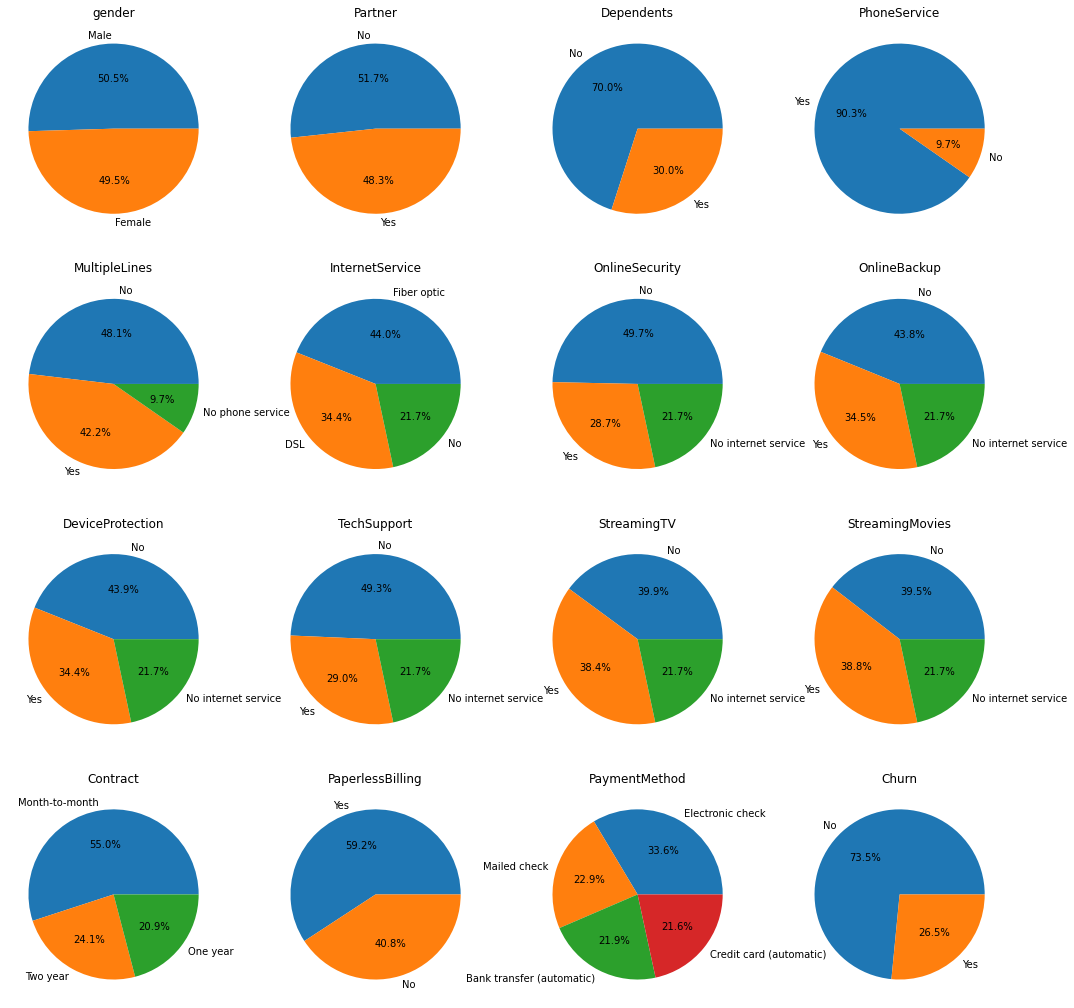

In [24]:
testDf, cols = generatePieCharts(telecomDf)

#### Insights from the above charts

**<span style="color:blue">Observations</span>**

It can be seen from the pie charts above that,
- Customers without internet service (21.7%), as expected, also don't have availed/needed services like OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
- Close to 60% customers have opted for PaperlessBilling option, which indicates growing trend of digital-friendliness and eco-awareness
- There is almost no gender gap among customers as we can see that the proportions of Male and Female customers are close to 50%

#### Encode all the appropriate Categorical features with the best suitable approach

In [25]:
telecomDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   int64   
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

#### Check the distribution of categories under each feature

In [26]:
# Check distribution of all the categories in categorical columns
for feature in telecomDf.columns: # Loop through all columns in the dataframe
    if telecomDf[feature].dtype == 'category' and feature != 'customerID': # Only apply for columns with categorical strings
        print("\n",feature,"\n")
        print(telecomDf[feature].value_counts())



 gender 

Male      3555
Female    3488
Name: gender, dtype: int64

 Partner 

No     3641
Yes    3402
Name: Partner, dtype: int64

 Dependents 

No     4933
Yes    2110
Name: Dependents, dtype: int64

 PhoneService 

Yes    6361
No      682
Name: PhoneService, dtype: int64

 MultipleLines 

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

 InternetService 

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

 OnlineSecurity 

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

 OnlineBackup 

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

 DeviceProtection 

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

 TechSupport 

No                     3473
Yes                    

In [27]:
# Prepare a dictionary to encode numerical values for categorical features
# Most of the features are of binary types, they can easily be encoded with numeric values.

replacementStruct = {
    "gender" :     {"Male": 1, "Female": 2},
    "Partner" :    {"No": 0, "Yes":1},
    "Dependents" : {"No": 0, "Yes":1},
    "PhoneService" : {"No": 0, "Yes":1},
    "MultipleLines" : {"No": 0, "Yes":1, "No phone service": -1},
    "InternetService" : {"No": -1, "DSL": 1, "Fiber optic": 2},
    "OnlineSecurity" : {"No": 0, "Yes":1, "No internet service": -1},
    "OnlineBackup" : {"No": 0, "Yes":1, "No internet service": -1},
    "DeviceProtection" : {"No": 0, "Yes":1, "No internet service": -1},
    "TechSupport" : {"No": 0, "Yes":1, "No internet service": -1},
    "StreamingTV" : {"No": 0, "Yes":1, "No internet service": -1},
    "StreamingMovies" : {"No": 0, "Yes":1, "No internet service": -1},
    "PaperlessBilling" : {"No": 0, "Yes":1},
    "Churn" : {"No": 0, "Yes":1}
}
                
# Columns for one hot encoding, these columns have multiple types of categorical observations.
    
oneHotCols=["Contract", "PaymentMethod"]


In [28]:
# Replace values in categorical columns using dictionary
telecomData = telecomDf.replace(replacementStruct)

# One hot encoding
telecomData = pd.get_dummies(telecomData, columns=oneHotCols)
telecomData.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,2,0,1,0,1,0,-1,1,0,1,...,29.85,29.85,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,1,0,...,56.95,1889.50,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,1,...,53.85,108.15,1,1,0,0,0,0,0,1
3,1,0,0,0,45,0,-1,1,1,0,...,42.30,1840.75,0,0,1,0,1,0,0,0
4,2,0,0,0,2,1,0,2,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0
5,2,0,0,0,8,1,1,2,0,0,...,99.65,820.50,1,1,0,0,0,0,1,0
6,1,0,0,1,22,1,1,2,0,1,...,89.10,1949.40,0,1,0,0,0,1,0,0
7,2,0,0,0,10,0,-1,1,1,0,...,29.75,301.90,0,1,0,0,0,0,0,1
8,2,0,1,0,28,1,1,2,0,0,...,104.80,3046.05,1,1,0,0,0,0,1,0
9,1,0,0,1,62,1,0,1,1,1,...,56.15,3487.95,0,0,1,0,1,0,0,0


In [29]:
telecomData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   gender                                   7043 non-null   category
 1   SeniorCitizen                            7043 non-null   int64   
 2   Partner                                  7043 non-null   category
 3   Dependents                               7043 non-null   category
 4   tenure                                   7043 non-null   int64   
 5   PhoneService                             7043 non-null   category
 6   MultipleLines                            7043 non-null   category
 7   InternetService                          7043 non-null   category
 8   OnlineSecurity                           7043 non-null   category
 9   OnlineBackup                             7043 non-null   category
 10  DeviceProtection                    

Let's convert the features into numerical type

In [30]:
# Convert features into numerical types
for feature in telecomData.columns: # Loop through all columns in the dataframe
    if telecomData[feature].dtype == 'category' and feature != 'customerID': # Only apply for columns with categorical strings
        telecomData[feature] = telecomData[feature].astype('int')

telecomData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   MultipleLines                            7043 non-null   int64  
 7   InternetService                          7043 non-null   int64  
 8   OnlineSecurity                           7043 non-null   int64  
 9   OnlineBackup                             7043 non-null   int64  
 10  DeviceProtection                         7043 no

The above procedure completes the encoding of all the categorical features, making the data ready to apply ensemble techniques

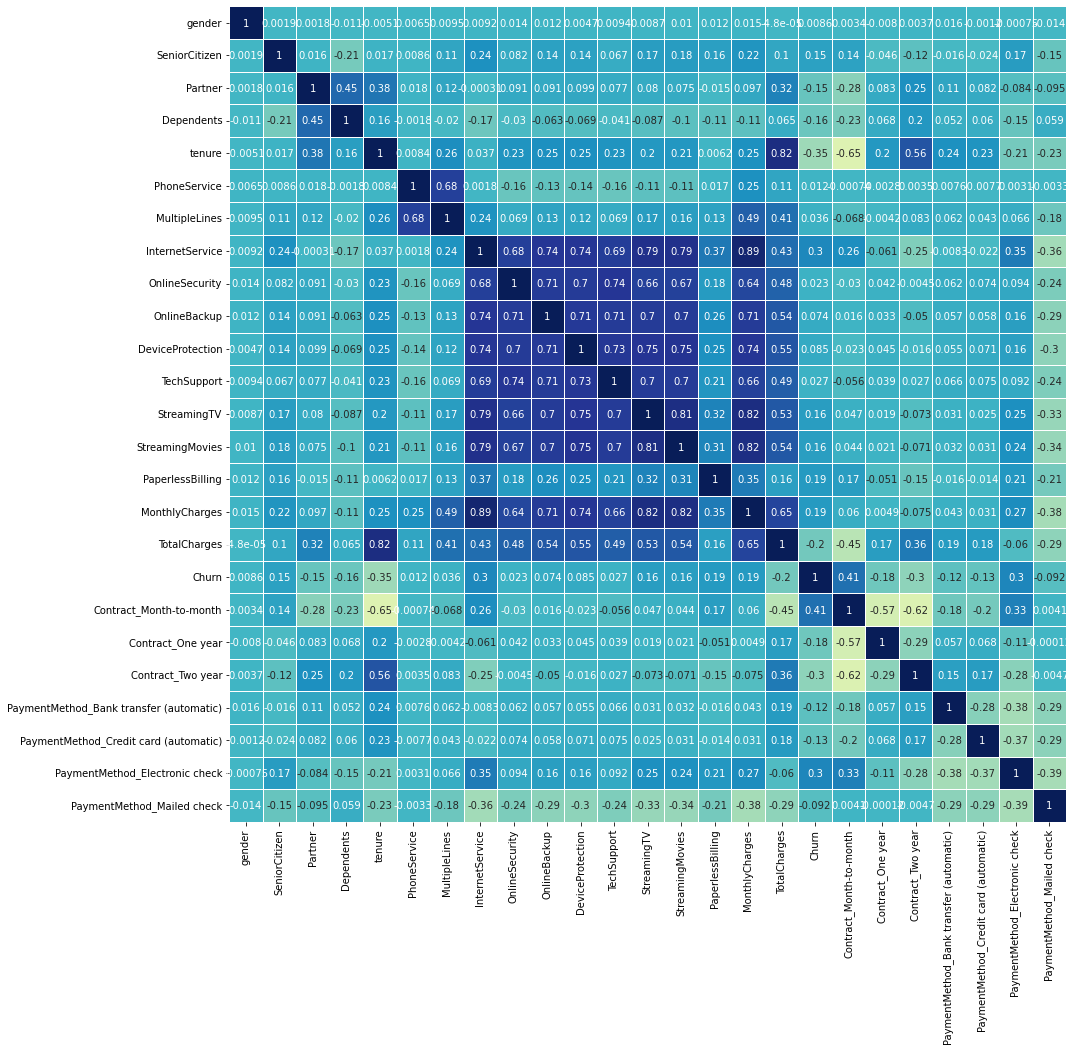

In [31]:
# Generate heatmap for pair-wise correlation between features
plt.figure(figsize=(15,15))
sns.heatmap(telecomData.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

**<span style="color:blue">Observations</span>**
- All the features related to internet services are highly correlated e.g. InternetService, OnlineSecurity, OnlineBackup, etc.

#### Split the data into 80% train and 20% test

In [32]:
X = telecomData.drop("Churn", axis=1)
y = telecomData['Churn']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=3)

In [34]:
len(X), len(X_train), len(X_test)

(7043, 5634, 1409)

In [35]:
# % of Test data
round((len(X_test)/len(X))*100, 1)

20.0

In [36]:
# % of Train data
round((len(X_train)/len(X))*100, 1)

80.0

#### Normalize/Standardize the data with the best suitable approach

- The advantage of decision tree based method is that they do not require normalization and scaling of the data.
- For the sake of running XGBoost classsifier, we can standardize the initial numeric features in the data i.e. `MonthlyCharges` and `TotalCharges`, this may as well help speed up calculations in training/testing steps

In [37]:
X = telecomData.drop("Churn", axis=1)

In [38]:
colsToScale = ['MonthlyCharges', 'TotalCharges']

In [39]:
# Statistical summary before scaling 
X[colsToScale].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.85,118.75
TotalCharges,7043.0,2283.300441,2265.000258,18.80,402.225,1400.55,3786.60,8684.80


In [40]:
X['MonthlyCharges'] = (X['MonthlyCharges'] - X['MonthlyCharges'].mean())/X['MonthlyCharges'].std(ddof=0)
X['TotalCharges'] = (X['TotalCharges'] - X['TotalCharges'].mean())/X['TotalCharges'].std(ddof=0)

In [41]:
# Statistical summary after scaling 
X[colsToScale].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,-6.406285e-17,1.000071,-1.54586,-0.972540,0.185733,0.833833,1.794352
TotalCharges,7043.0,8.070910e-17,1.000071,-0.99985,-0.830556,-0.389763,0.663755,2.826469


**<span style="color:blue">Observations</span>**
- It can be seen that the means and standard deviations of numeric features scaled using Z-scores have become closer to 0 and 1 respectively.
- This confirms the succesful scaling/standardiation of those features

In [42]:
# Re-splitting the data in train and test sets after scaling of numeric features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=3)

### Model building and Improvement

#### Train a model using XGBoost and print best performing parameters along with train and test performance

In the initial phase of training, let's train XGBoost only with different `min_child_weight` parameter values and see how the test score varies

In [43]:
child_weight_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
for cw in child_weight_range:
    xgb_classifier = xgb.XGBClassifier(min_child_weight = cw)
    xgb_classifier.fit(X_train, y_train)
    train_XG.append(xgb_classifier.score(X_train, y_train))
    test_XG.append(xgb_classifier.score(X_test, y_test))

In [44]:
xgBoostLrScores = pd.DataFrame({
    'min_child_weight' : child_weight_range,
    'Training_Score': train_XG,
    'Testing_Score': test_XG
})

In [45]:
# Print models in descending Test score
xgBoostLrScores.sort_values(by=['Testing_Score'], ascending=False).head()

,min_child_weight,Training_Score,Testing_Score
19,0.96,0.933440,0.804116
10,0.51,0.949947,0.803407
3,0.16,0.953852,0.801987
11,0.56,0.942847,0.799858
8,0.41,0.948349,0.796309


**<span style="color:blue">Observations</span>**
- It can be observed that XGBoost gives best test accuracy of ~ 80% at min_child_weight of 0.96.

In [46]:
# Rest of the parameters used by XGBoost
xgb.XGBClassifier(min_child_weight = 0.96)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0.96, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

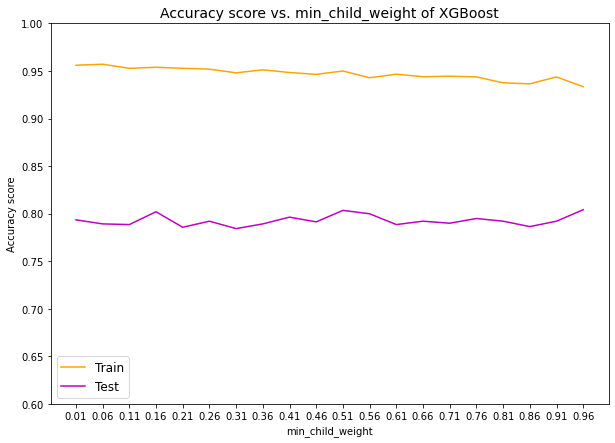

In [47]:
# Plotting change in Training and Testing accuracy scores over different learning rates
fig = plt.figure(figsize=(10, 7))
plt.plot(child_weight_range, train_XG, c='orange', label='Train')
plt.plot(child_weight_range, test_XG, c='m', label='Test')
plt.xlabel('min_child_weight')
plt.xticks(child_weight_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. min_child_weight of XGBoost', size=14)
plt.show()


**<span style="color:blue">Observations</span>**
- As mentioned previously, It can be seen that XGBoost gives best test accuracy of ~ 80% at min_child_weight of 0.96.
- However, the `issue of overfitting` is clearly evident for other values of learning rate, i.e. model has high training accuracy but lower test accuracy.

In [48]:
# Rest of the parameters used by XGBoost
xgb.XGBClassifier(min_child_weight = 0.96)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0.96, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
xgb_classifier = xgb.XGBClassifier(min_child_weight = 0.96)
xgb_classifier.fit(X_train, y_train)
y_predict = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict, labels=[0, 1])

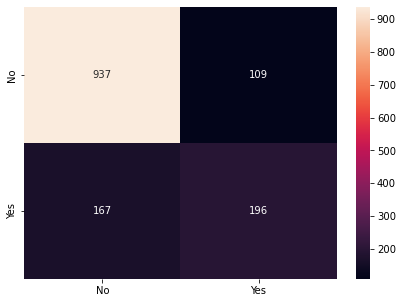

In [50]:
# Plot heatmap for confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g');

In [51]:
# Classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1046
           1       0.64      0.54      0.59       363

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



####  Improve performance of the XGBoost as much as possible and print best performing parameters along with train and test performance

In [52]:
# Define parameters for model tuning
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": np.arange(0.01, 0.2, 0.05),
    "min_child_weight": [0, 1, 2, 3, 4, 5],
    "subsample": [0.8],
}

In [53]:
# Initialize classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize Grid Search
grid_cv = GridSearchCV(xgb_classifier, param_grid, n_jobs=-1, cv=3, scoring="accuracy")

# Fit the model
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [54]:
# Best model parameters based on grid search
grid_cv.best_params_

{'learning_rate': 0.16000000000000003,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 50,
 'subsample': 0.8}

In [55]:
# Build best model
xgb_best_classifier = xgb.XGBClassifier(
    n_estimators = 50,
    learning_rate = 0.16000000000000003,
    max_depth = 3,
    min_child_weight = 4,
    subsample = 0.8
)

In [56]:
# Compute scores on training and test data sets
xgb_best_classifier.fit(X_train, y_train)
train_bestScore = xgb_best_classifier.score(X_train, y_train)
test_bestScore = xgb_best_classifier.score(X_test, y_test)

In [57]:
print(train_bestScore, test_bestScore)

0.8193113241036564 0.8147622427253371


In [58]:
# Confusion matrix
y_predict = xgb_best_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict, labels=[0, 1])

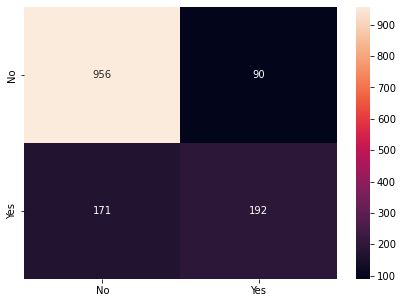

In [59]:
# Plot heatmap for confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g');

In [60]:
# Classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1046
           1       0.68      0.53      0.60       363

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.81      0.81      0.81      1409



**<span style="color:blue">Observations</span>**

It can be seen that overall performance of the model is increased as follows,
- Accuracy and F1 score has increased marginally by 1% for both the classes 
- Precision score has increased by 4% for class 1, i.e. Churn = Yes